In [1]:
%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6.0
plt.rcParams['ytick.major.size'] = 6.0
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = False

In [3]:
## Set the linear matter power spectrum

from scipy.interpolate import InterpolatedUnivariateSpline

pk_data = np.loadtxt('pk_lin.dat')
pk_spl = InterpolatedUnivariateSpline(np.log(pk_data[:,0]), np.log(pk_data[:,1]))

def get_pk_lin(k):
    return np.exp(pk_spl(np.log(k)))

## Computing non-Gaussian covariance

In [4]:
sys.path.append('..')
from power_cov import PowerSpecCovFFT

In [5]:
cov = PowerSpecCovFFT()

Loading master integrals...
Loading coefficient functions...
Loading integral formulae...
done.


In [6]:
## Set the FFTLog
config_fft = {'nu':-0.3, 'kmin':1e-5, 'kmax':1e+1, 'nmax':512}
cov.set_power_law_decomp(config_fft)

## Set the linear matter power spectrum
cov.set_pk_lin(get_pk_lin)

## Set the parameters
vol = 1e+9 # survey volume [(Mpc/h)^3]
ndens = 1e-4 # number density [(Mpc/h)^{-3}], for the shot-noise part
bias = {'b1':2, 'b2':-1, 'bG2':0.1, 'b3':0, 'bG3':0, 'bdG2':0, 'bGamma3':0} # galaxy bias parameters
fgrowth = 0.528 # linear growth rate
cov.set_params(vol, ndens, fgrowth, bias)

In [7]:
%%time

## k-bin setting
kmin = 0.005
kmax = 0.4
dk = 0.01
k = np.arange(kmin, kmax, dk)
k2, k1 = np.meshgrid(k, k)

## Precompute the master integrals Eq. (15)
cov.calc_master_integral(k1, k2)

## Compute the elementary integrals Eq. (13)
cov.calc_base_integral()

CPU times: user 21.6 s, sys: 3.02 s, total: 24.6 s
Wall time: 24.6 s


In [8]:
%%time
## Compute the non-Gaussian covariance for each combination of multipoles
cov_00 = cov.get_cov_T0(0, 0, k1, k2)
cov_22 = cov.get_cov_T0(2, 2, k1, k2)
cov_44 = cov.get_cov_T0(4, 4, k1, k2)
cov_02 = cov.get_cov_T0(0, 2, k1, k2)
cov_04 = cov.get_cov_T0(0, 4, k1, k2)
cov_24 = cov.get_cov_T0(2, 4, k1, k2)

CPU times: user 83.2 ms, sys: 3.85 ms, total: 87 ms
Wall time: 99.1 ms


### Non-Gaussian covariance (without shot noise)

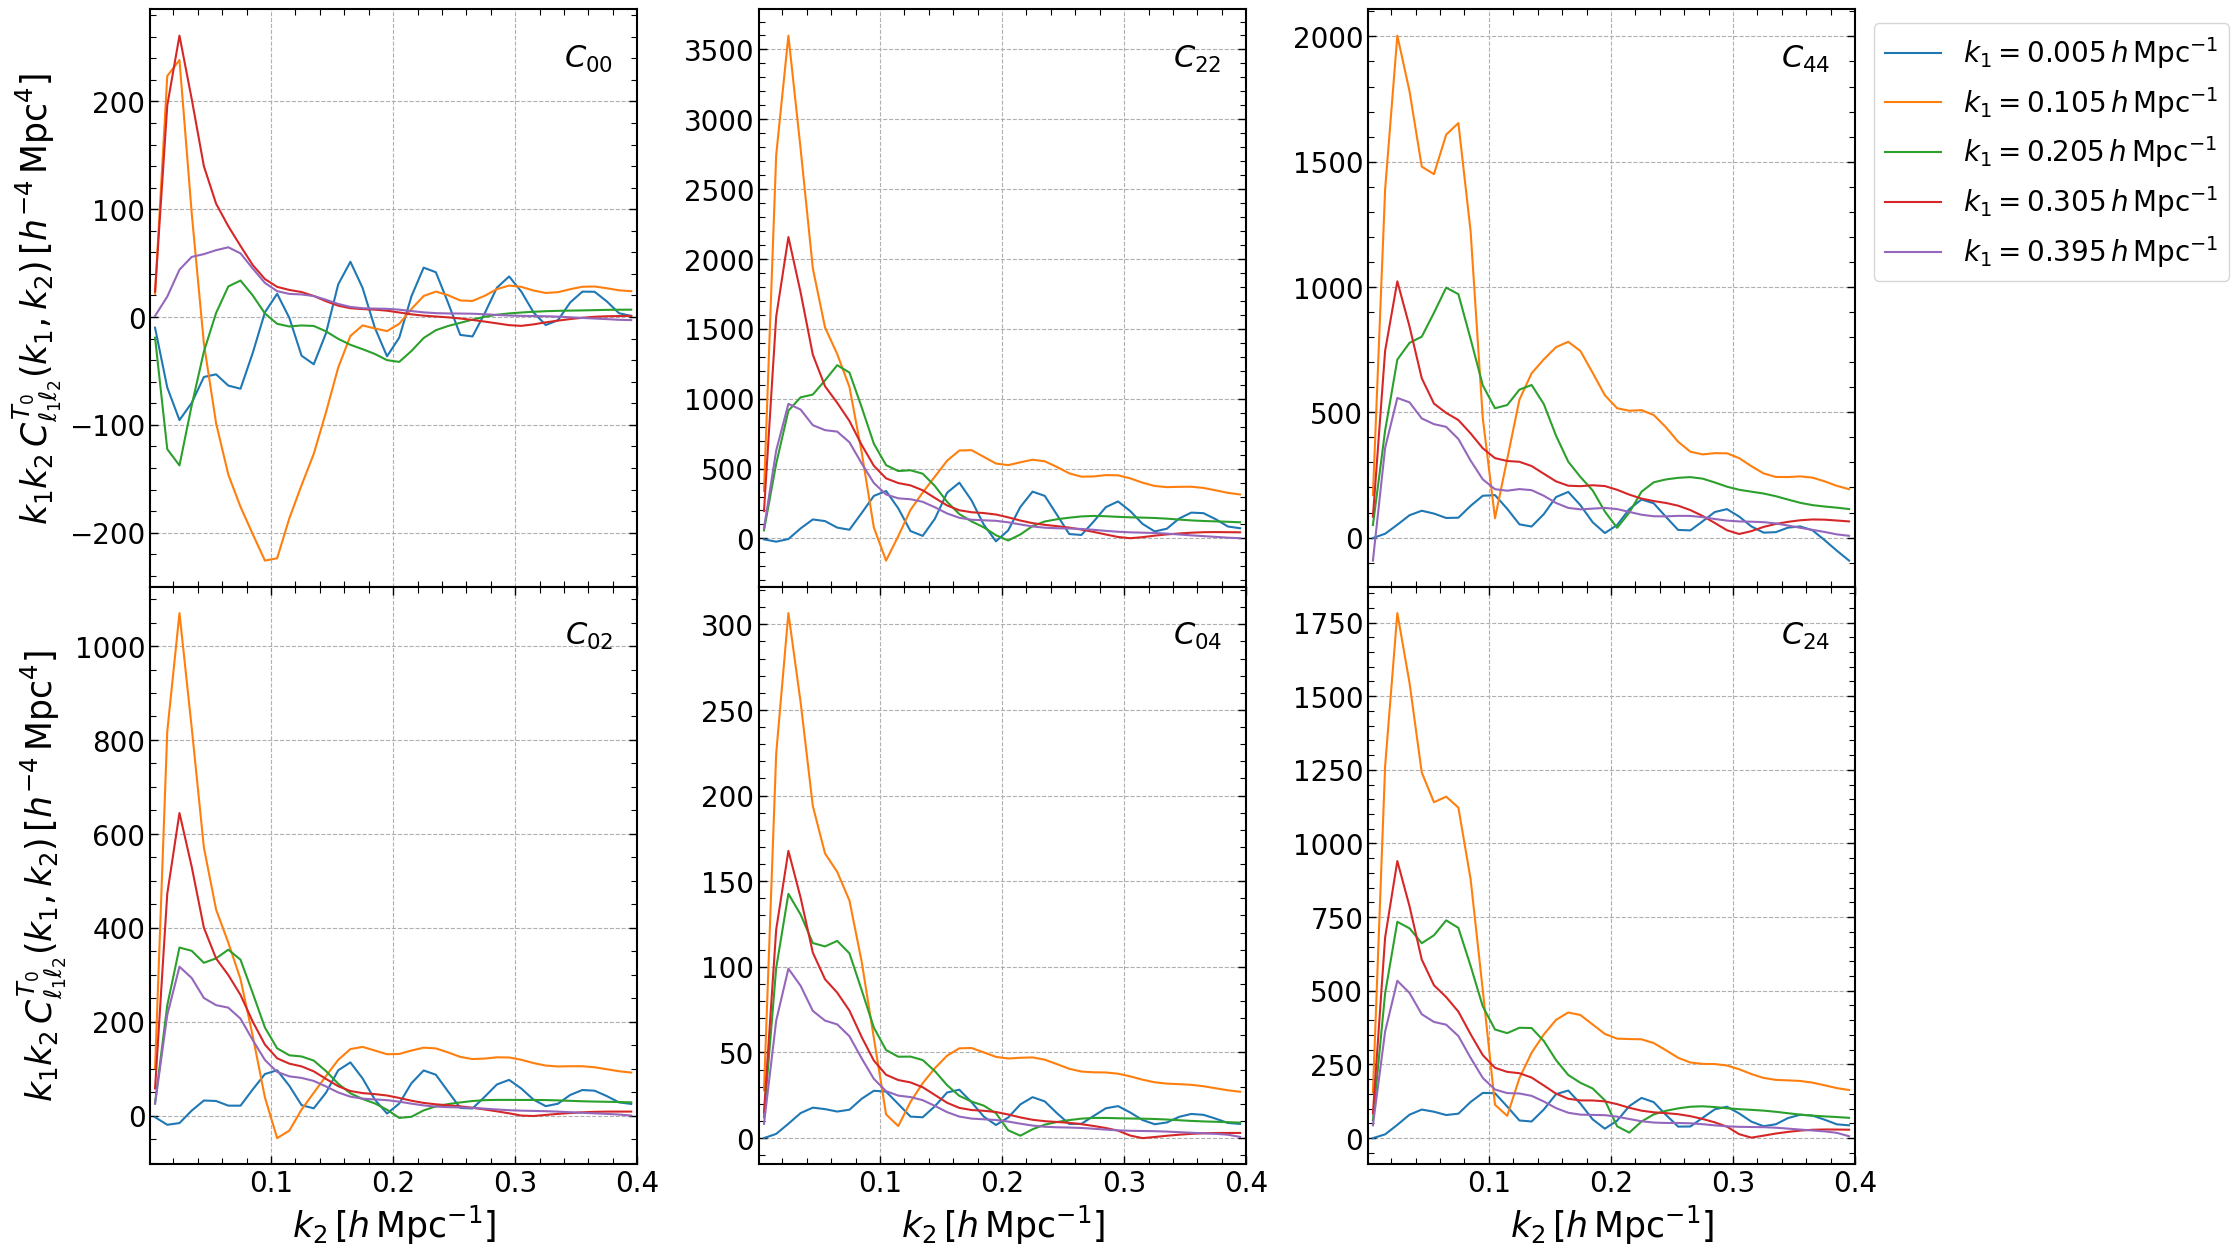

In [9]:
fig = plt.figure(figsize=(22,15))
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

k = np.arange(kmin, kmax, dk)
idx_list = [0,10,20,30,39]

gs_master = GridSpec(nrows=2, ncols=3, height_ratios=[1,1], hspace=0., wspace=0.25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 0
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$k_1 k_2 \, C^{T_0}_{\ell_1\ell_2}(k_1,k_2) \, [h^{-4}\,\mathrm{Mpc}^{4}]$', fontsize=25)
ax.tick_params(axis='x',colors='None')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1])
ax = fig.add_subplot(gs[:,:])
l1 = 2
l2 = 2
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.tick_params(axis='x',colors='None')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2])
ax = fig.add_subplot(gs[:,:])
l1 = 4
l2 = 4
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.tick_params(axis='x',colors='None')
ax.legend(fontsize=20, bbox_to_anchor=(1.01, 1.0), loc='upper left')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[3])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 2
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)
ax.set_ylabel(r'$k_1 k_2 \, C^{T_0}_{\ell_1\ell_2}(k_1,k_2) \, [h^{-4}\,\mathrm{Mpc}^{4}]$', fontsize=25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[4])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 4
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[5])
ax = fig.add_subplot(gs[:,:])
l1 = 2
l2 = 4
cov_pl = cov.get_cov_T0(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)

axs = plt.gcf().get_axes()
for ax in axs:
    plt.sca(ax)
    plt.xlim(0.001, kmax)
    plt.grid(linestyle='--')

### Non-Gaussian covariance (shot-noise part)

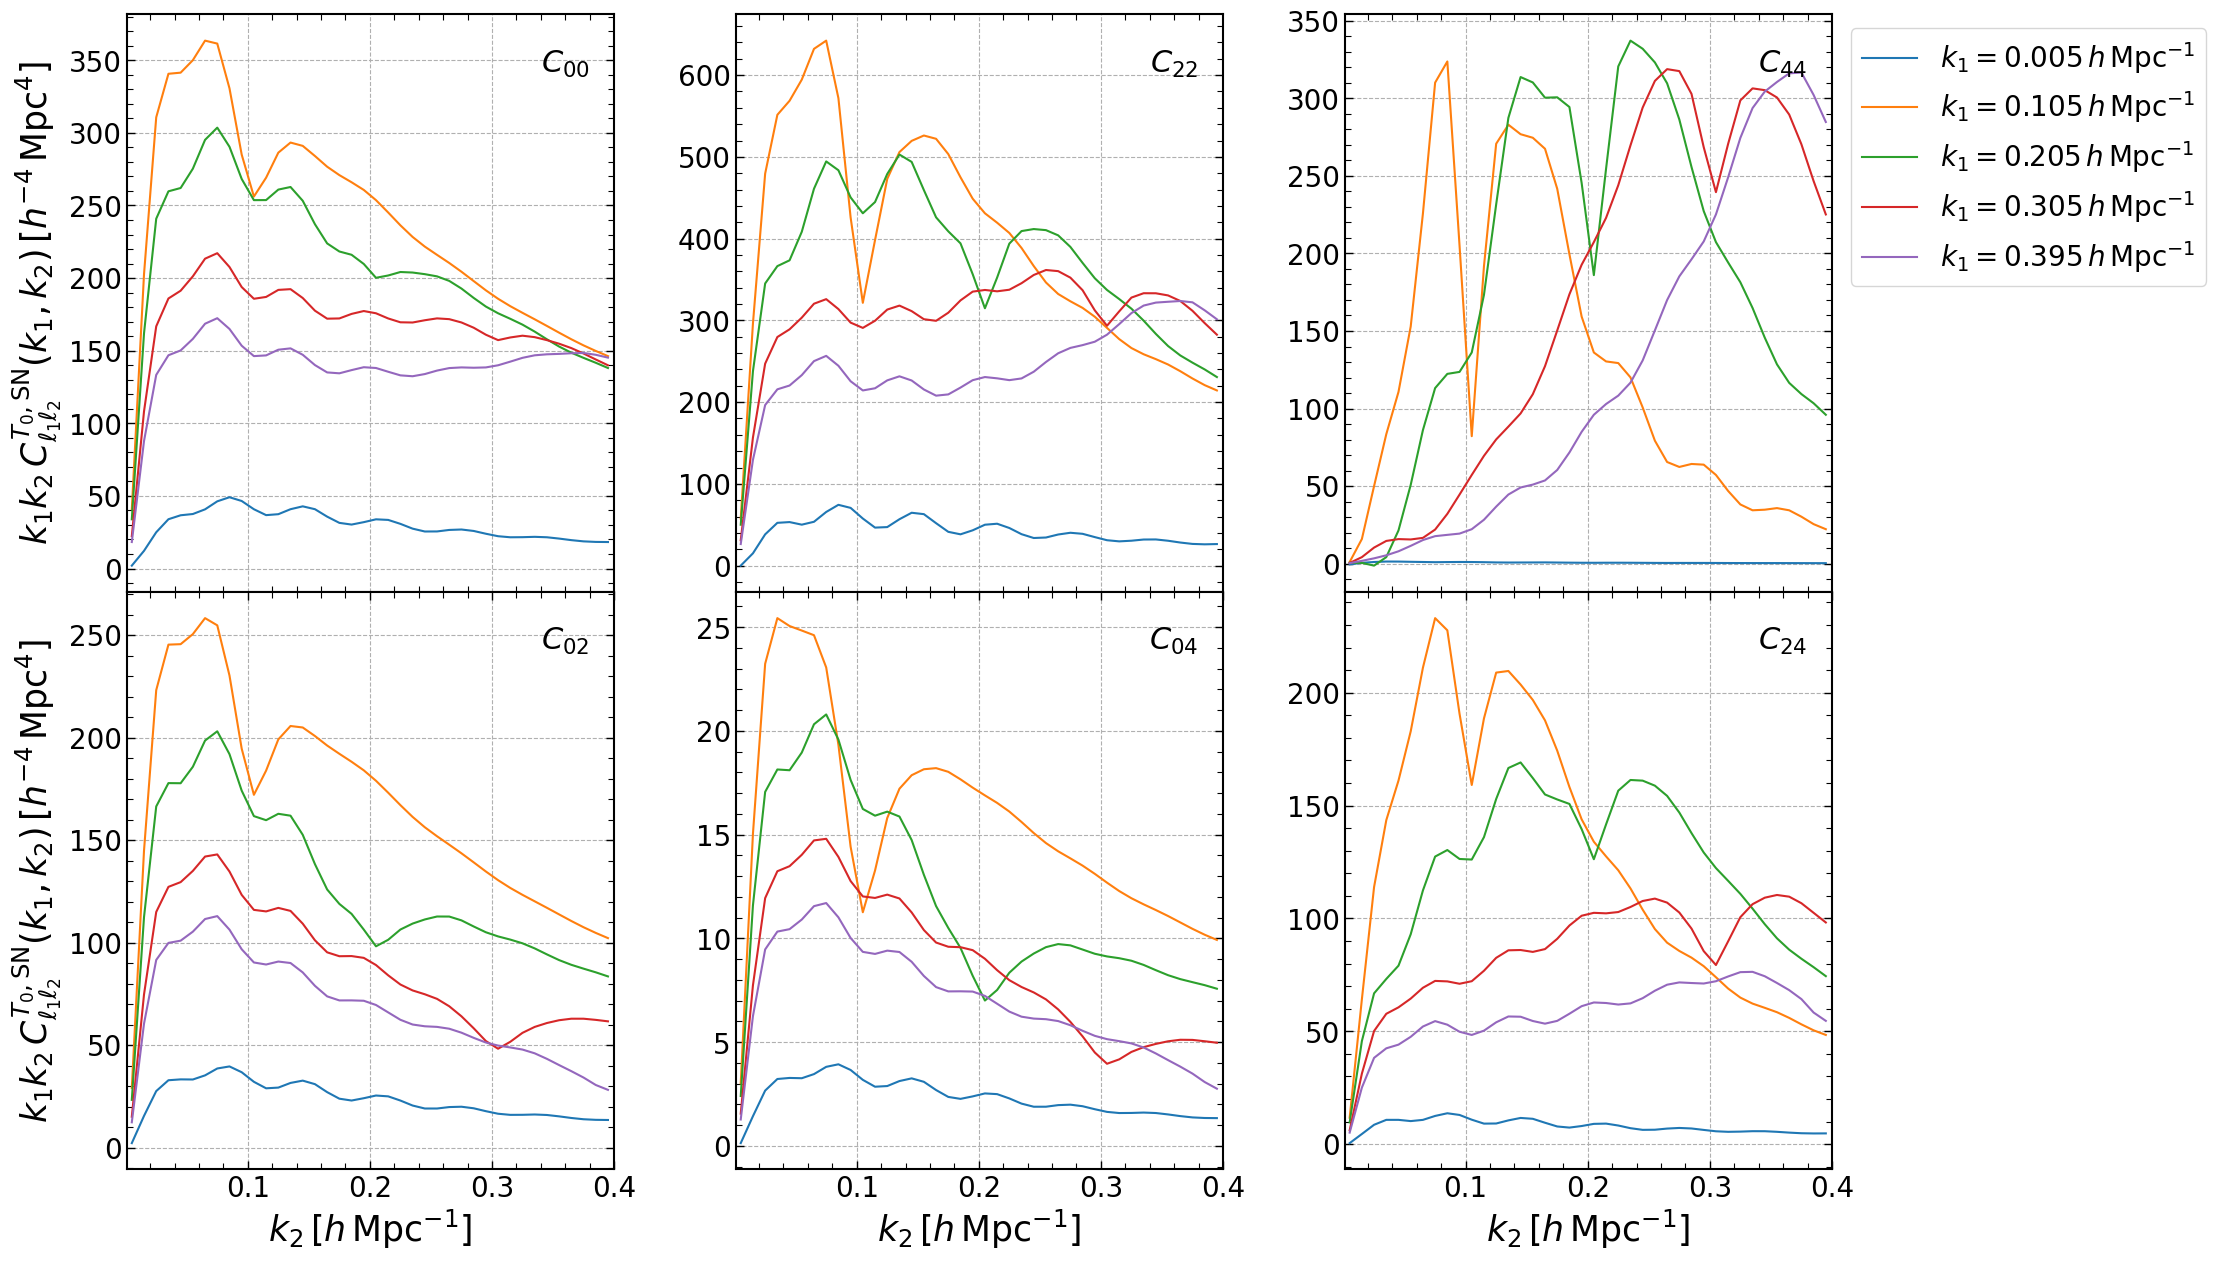

In [10]:
fig = plt.figure(figsize=(22,15))
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

k = np.arange(kmin, kmax, dk)
idx_list = [0,10,20,30,39]

gs_master = GridSpec(nrows=2, ncols=3, height_ratios=[1,1], hspace=0., wspace=0.25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 0
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$k_1 k_2 \, C^{T_0,\mathrm{SN}}_{\ell_1\ell_2}(k_1,k_2) \, [h^{-4}\,\mathrm{Mpc}^{4}]$', fontsize=25)
ax.tick_params(axis='x',colors='None')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1])
ax = fig.add_subplot(gs[:,:])
l1 = 2
l2 = 2
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.tick_params(axis='x',colors='None')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2])
ax = fig.add_subplot(gs[:,:])
l1 = 4
l2 = 4
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.tick_params(axis='x',colors='None')
ax.legend(fontsize=20, bbox_to_anchor=(1.01, 1.0), loc='upper left')

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[3])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 2
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)
ax.set_ylabel(r'$k_1 k_2 \, C^{T_0,\mathrm{SN}}_{\ell_1\ell_2}(k_1,k_2) \, [h^{-4}\,\mathrm{Mpc}^{4}]$', fontsize=25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[4])
ax = fig.add_subplot(gs[:,:])
l1 = 0
l2 = 4
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)

gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[5])
ax = fig.add_subplot(gs[:,:])
l1 = 2
l2 = 4
cov_pl = cov.get_cov_T0_SN(l1, l2, k1, k2)
for i, idx in enumerate(idx_list):
    ax.plot(k, k[idx] * k * cov_pl[idx], ls='-', c=color[i], alpha=1, label='$k_1 = %s\,h\,\mathrm{Mpc}^{-1}$' % ('{:.3f}'.format(k[idx])))
ax.text(0.95, 0.9, r'$C_{%s%s}$' % (l1,l2), fontsize=22, transform=ax.transAxes, ha='right')
ax.set_xlabel(r'$k_2\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=25)

axs = plt.gcf().get_axes()
for ax in axs:
    plt.sca(ax)
    plt.xlim(0.001, kmax)
    plt.grid(linestyle='--')